<p>
In this notebook I created a model for calculating similarity between items. This model is used for cold start problem where new users has not enough interactions with the system and colaborative filtering can not recommend relevant products. In this scenario the most similar items to items that visitor interact with are found and these are used for recommendations. If we had information about users such a gender, age, location, preferences it would be better to create model for finding most similar users for a given user. Then the system would recommend products the similar users interacted with to the new user.
</p>
<p>
<p>Dataset catalog contains information about products. These informations - features are preprocessed and used for calculating similarity. Easiest way how to make such a model would be to create single matrix with all the features and use unsupervised Neares neigbourhood algorithm. Probel with this is that nearest neigbourhood algorithm can not find which features are more important than the others - when we are making recommendations products that match with geneder are probably more relevant than products that match with brand. Thats why I created nearest neigbourhood model for all features separately. Outputs from all models - distances are heuristically weighted and combined to single output. This model is then used for making recommendations based on similarity.

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
products = pd.read_csv("dataset_catalog.csv")
products.head()

,product_id,category_id,category_path,brand,gender,description,price
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
2,3,2,Clothes,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
4,5,3,Children|Children's Footwear|Children's Sport ...,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73


In [46]:
products.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28369 entries, 0 to 28368
Data columns (total 7 columns):
product_id       28369 non-null int64
category_id      28369 non-null int64
category_path    28369 non-null object
brand            28369 non-null object
gender           28369 non-null object
description      26927 non-null object
price            28369 non-null float64
dtypes: float64(1), int64(2), object(4)
memory usage: 1.5+ MB


<h1>Categories</h1>

The catalog contains two features about product category - category_id and cateogry_path. The easiest way how to find similar items based on category would be to check if they match on category_id. But if we chceck category_path we can see that some categories are more similar than others. Products with category_id 37(Women|Women's Footwear|Women's Ballerinas|Slip on) and category_id 41( Women|Women's Footwear|Women's Platform Shoes ) definitely share some similarity. Thats why I decided not to use category_id but category_path.

In [47]:
products = pd.read_csv("dataset_catalog.csv").drop(columns=['brand', 'gender', 'description', 'price'])
print(products.shape)
products.head()

(28369, 3)


,product_id,category_id,category_path
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
2,3,2,Clothes
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
4,5,3,Children|Children's Footwear|Children's Sport ...


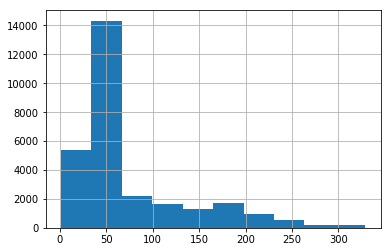

In [48]:
products.category_id.hist()

The idea behind using cateogry_path is to split category_paths on every "|" character and splited key words are used as separate features. In the following cell I took unique category_paths and created dataframe with key-word features.

In [49]:
categories = {}
category_paths = products[['category_id', 'category_path']].drop_duplicates()
category_path_part_names = set()
for i, r in category_paths.iterrows():
    for cat in r.category_path.split('|'):
        if cat not in category_paths:
            category_paths[cat] = 0
            category_path_part_names.add(cat)
        category_paths.loc[i, cat] = 1
print(list(category_path_part_names)[:10])
category_paths.head()

['Ski Goggles', "Children's Ankle Boots", 'Baseball Caps', "Sale - Men's footwear", "Girl's Sets", "Sale - Women's Tracksuits", 'Sports T-Shirts', "Women's Shawls and Scarves", "Sale - Men's accessories", 'Suitcases']


,category_id,category_path,Sports,Outdoor,Outdoor Shoes,Children's Outdoor Shoes,Clothes,Children,Children's Footwear,Children's Sport Footwear,...,Sports Jackets,Water Bottles,Women's Outdoor Shorts,Golf Gloves,Sale - Women's Accessories,Men's Trekking sandals,Children's Flip Flops,Skirts,Men's Cycling Jerseys,Boxing Accessories
0,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,1,1,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,Clothes,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,Children|Children's Footwear|Children's Sport ...,0,0,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
6,4,Children|Children's Footwear|Sandshoes,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
10,5,Children|Children's Footwear|For the Little Ones,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0


Category features are merged to the default dataframe.

In [50]:
products_with_column_categories = pd.merge(products, category_paths,  how='left', left_on=['category_id'], right_on = ['category_id'])
products_with_column_categories = products_with_column_categories.drop(columns=['product_id', 'category_id', 'category_path_x', 'category_path_y'])
products_with_column_categories.head()

,Sports,Outdoor,Outdoor Shoes,Children's Outdoor Shoes,Clothes,Children,Children's Footwear,Children's Sport Footwear,Sandshoes,For the Little Ones,...,Sports Jackets,Water Bottles,Women's Outdoor Shorts,Golf Gloves,Sale - Women's Accessories,Men's Trekking sandals,Children's Flip Flops,Skirts,Men's Cycling Jerseys,Boxing Accessories
0,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


Final data for category nearest neigbourhood model.

In [51]:
cat_data = products_with_column_categories.values
cat_data, cat_data.shape

(array([[1, 1, 1, ..., 0, 0, 0],
        [1, 1, 1, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=int64), (28369, 355))

All the models that calculate similarity based on single feature are encapsulated in its own class which is inherited from abstract class Similarity. Abstract class has two main methods: train - preprocess data and train NN model and get_similarities - returns list of all product similarities - list is sorted by product ids not similarity. Here I show only simplified version of the classes. 


In [52]:
from sklearn.neighbors import NearestNeighbors
from abc import ABC, abstractmethod

class Similarity(ABC):
    @abstractmethod
    def train(self, data):
        pass
    @abstractmethod
    def get_similarities(self, product_id):
        pass
    
class CategorySimilarity(Similarity):
    
    def train(self, data):
        self.data = data
        self.model = NearestNeighbors(n_neighbors=5, metric='cosine')
        self.model.fit(data)
    
    def get_similarities(self, product_id):
        product_count = self.data.shape[0] #we want to find distances to all products
        product_idx = product_id - 1 #input matrix has different indexing than product ids
        d = [self.data[product_idx]] #selecting produt features
        distances, neighbours = self.model.kneighbors(d, product_count, return_distance=True) #distances are calculated
        distances = distances.flatten() 
        neighbours = neighbours.flatten()
        similarity = np.ones(distances.shape) - distances #distances are converted to similarity
        all_product_similarities = np.zeros(product_count)
        all_product_similarities[neighbours] = similarity #list is not sorted by similarity but product ids
        return all_product_similarities #returns list of similarities 
        
categorySimilarity   = CategorySimilarity()
categorySimilarity.train(cat_data)


In [14]:
products.head(10)

,product_id,category_id,category_path
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
2,3,2,Clothes
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...
4,5,3,Children|Children's Footwear|Children's Sport ...
5,6,3,Children|Children's Footwear|Children's Sport ...
6,7,4,Children|Children's Footwear|Sandshoes
7,8,4,Children|Children's Footwear|Sandshoes
8,9,3,Children|Children's Footwear|Children's Sport ...
9,10,3,Children|Children's Footwear|Children's Sport ...


Here we can see that values coresponds to category_path similarity. Product with ids 7 and 8 are identical(by category_path) and products 7 and 9  are quite similar.

In [24]:
test_id1 = 7
categorySimilarity.get_similarities(test_id1)[:20]

array([0.        , 0.        , 0.        , 0.        , 0.66666667,
       0.66666667, 1.        , 1.        , 0.66666667, 0.66666667,
       0.66666667, 0.66666667, 0.66666667, 1.        , 0.66666667,
       0.66666667, 0.81649658, 0.81649658, 0.81649658, 0.66666667])

<h1>Brand</h1>


Similarity based on brand is simple. We just compare if two product share same brand.

In [54]:
products = pd.read_csv("dataset_catalog.csv").drop(columns=['category_id', 'category_path', 'gender', 'description', 'price'])
print(products.shape)
products.head()

(28369, 2)


,product_id,brand
0,1,Firetrap
1,2,Firetrap
2,3,Firetrap
3,4,Firetrap
4,5,Nike


In [55]:
products.brand.value_counts().head(10)

Adidas           1799
Accessories      1780
Nike             1678
Pierre Cardin    1467
Lee Cooper        845
Puma              821
Karrimor          773
Firetrap          766
Slazenger         715
SoulCal           679
Name: brand, dtype: int64

In [56]:
brands = products.brand.values
brands.shape

(28369,)

I used OneHotEncoder for encoding brands and dot product results in matrix n_products x n_products where [i,j] position is 1 if product i has same brand as product j and 0 if not.

In [57]:
from sklearn.preprocessing import OneHotEncoder

class BrandSimilarity(Similarity):
    
    def train(self, data):
        self.data = data
        OHE = OneHotEncoder()
        ohe_mat = OHE.fit_transform(data, 1)
        self.model = ohe_mat.dot(ohe_mat.T)
        
    def get_similarities(self, product_id):
        product_idx = product_id - 1
        return np.array(self.model[product_idx].todense()).flatten()
        

In [25]:
products.head(20)

,product_id,brand
0,1,Firetrap
1,2,Firetrap
2,3,Firetrap
3,4,Firetrap
4,5,Nike
5,6,Lonsdale
6,7,Dunlop
7,8,Slazenger
8,9,Under Armour
9,10,Nike


In [58]:
from sklearn.preprocessing import OneHotEncoder

brandSimilarity = BrandSimilarity()
brandSimilarity.train(products.brand.values.reshape(len(products.brand.values), 1))

product_test_id = 5
brandSimilarity.get_similarities(product_test_id)[:20]

array([0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0.])

<h1>Gender</h1>

Calculating similarity between products based on gender is more complicated than brand similarity. Here we can see that there are 5 types of genders: Man, Woman, Child, Other and Unisex. Because some gener types are more similar than others I created unique encoding which is used by NN model.

In [59]:
products = pd.read_csv("dataset_catalog.csv").drop(columns=['category_id', 'category_path', 'brand', 'description', 'price'])
print(products.shape)
products.head()

(28369, 2)


,product_id,gender
0,1,Child
1,2,Child
2,3,Child
3,4,Child
4,5,Child


<BarContainer object of 5 artists>

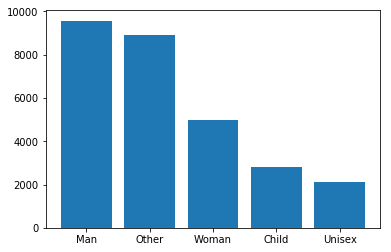

In [30]:
plt.bar(products.gender.value_counts().index, products.gender.value_counts().values)

The gender encoding is showed in table under following cell.

In [60]:
products['Man'] = 0
products['Woman'] = 0
products['Child'] = 0
products['Unisex'] = 0
products['Other'] = 0

indexes = products[products.gender == 'Man'].index
products.loc[indexes, 'Man'] = 1

indexes = products[products.gender == 'Woman'].index
products.loc[indexes, 'Woman'] = 1

indexes = products[products.gender == 'Other'].index
products.loc[indexes, 'Other'] = 1
products.loc[indexes, 'Man'] = 1
products.loc[indexes, 'Woman'] = 1
products.loc[indexes, 'Unisex'] = 1

indexes = products[products.gender == 'Child'].index
products.loc[indexes, 'Child'] = 1

indexes = products[products.gender == 'Unisex'].index
products.loc[indexes, 'Unisex'] = 1
products.loc[indexes, 'Man'] = 1
products.loc[indexes, 'Woman'] = 1

products.drop(columns=['product_id']).drop_duplicates().reset_index(drop=True).head()

,gender,Man,Woman,Child,Unisex,Other
0,Child,0,0,1,0,0
1,Man,1,0,0,0,0
2,Woman,0,1,0,0,0
3,Unisex,1,1,0,1,0
4,Other,1,1,0,1,1


In [61]:
gender_mat = products[['Man', 'Woman', 'Child', 'Unisex', 'Other']].values
gender_mat

array([[0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 0, 1, 0, 0],
       ...,
       [1, 0, 0, 0, 0],
       [1, 0, 0, 0, 0],
       [0, 0, 1, 0, 0]], dtype=int64)

The class in this simplified version is identical to  BrandSimilarity, only input encoding type is different.

In [62]:
class GenderSimilarity(Similarity):
    
    def train(self, data):
        self.data = data
        self.model = NearestNeighbors(n_neighbors=5,  metric='cosine')
        self.model.fit(data)
        
    def get_similarities(self, product_id):
        product_count = self.data.shape[0] 
        product_idx = product_id - 1
        distances, neighbours = self.model.kneighbors([self.data[product_idx]], product_count, return_distance=True)
        distances = distances.flatten()
        neighbours = neighbours.flatten()
        similarity = np.ones(distances.shape) - distances
        all_product_similarities = np.zeros(product_count)
        all_product_similarities[neighbours] = similarity
        
        return all_product_similarities


In [45]:
products.sample(10).head()

,product_id,gender,Man,Woman,Child,Unisex,Other
5191,5192,Man,1,0,0,0,0
20422,20423,Man,1,0,0,0,0
11859,11860,Other,1,1,0,1,1
14319,14320,Man,1,0,0,0,0
6231,6232,Unisex,1,1,0,1,0


The model results in these example values.<br>
man - man - 1<br>
man - unisex - 0.577<br>
man - woman - 0<br>
man - other - 0.5<br>
other - child - 0<br>
other - unisex - 0.866



In [68]:
#man man 1
#man unisex 0.577
#man child 0
#man woman 0
#woman other 0.5
#other child 0
#other unisex 0.866

genderSimilarity = GenderSimilarity()    
genderSimilarity.train(gender_mat)
test_id1 = 11860 #Other
test_id2 = 6232 #Unisex
test_idx2 = test_id2 - 1
genderSimilarity.get_similarities(test_id1)[test_idx2]

0.8660254037844388

<h1>Description</h1>

Similarity based on description of names of the products would be in the real life problem the most important one. We could use cosine similarity of texts or generate keywords and use them as features for NN model. In this problem, after preprocessing the texts I decided to not to use it at all.

In [360]:
products = pd.read_csv("dataset_catalog.csv").drop(columns=['category_id','category_path','brand','gender', 'price'])
print(products.shape)
products.head()

(28369, 2)


,product_id,description
0,1,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ..."
1,2,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ..."
2,3,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ..."
3,4,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ..."
4,5,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ..."


Product description contains unnecessary html tags which are stripped. Then I used basic NLP techniques for preprocessing text - removing non alphabet words, lowercasing, removing stop words and stemmatization of words.

In [361]:
from html.parser import HTMLParser

# https://stackoverflow.com/questions/753052/strip-html-from-strings-in-python
class MLStripper(HTMLParser):
    def __init__(self):
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.fed = []
    def handle_data(self, d):
        self.fed.append(d)
    def get_data(self):
        return ''.join(self.fed)
    
def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

import operator
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from gensim.utils import simple_preprocess

stemmer = SnowballStemmer('english')
en_stopwords = stopwords.words('english')
stops = set(stopwords.words('english'))

def stem_preprocess(texts):
    texts = simple_preprocess(texts, deacc=True, min_len=3)
    texts = [word for word in texts if word not in stops]
    texts = [stemmer.stem(word) for word in texts]
    return " ".join(texts)


In [362]:
products['description_preprocessed'] = products.description.apply(lambda x: stem_preprocess(strip_tags(str(x))))

After text preprocessing I noticed that description is not saying much about products. Description are very repetitive and mostly they contain information about product size, materials or no usefull information at all(e.g. "product code"). Thats why I decided not to use description for computing similarity. But if I had meaningfull product names or description I would use this simple text preprocessing, then I would use Tfidf vectorizer for encoding and NN model with cosine metrics for finding most similar texts.

In [363]:
products.description_preprocessed.value_counts()

product code                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            

In [364]:
strip_tags(products.loc[10].description)

"Puma Sequence V2 Trainers Child Girls These Puma Sequence V2 Trainers will put a spring in your little lady's step, crafted with two touch and close fastening straps, a padded tongue, ankle collar and insole, breathable mesh upper, thick contrasting midsole and textured sole, in striking colouring with classic Puma branding to complete the look.  > Child girl's trainers > 2 touch and close fastening straps > Padded tongue > Padded ankle collar > Breathable upper > Contrasting thick midsole > Textured sole > Striking colouring > Puma branding > Upper: Textile > Inner: Textile > Sole: Synthetic  For our full range of Kids Trainers visit                               Product code: 031548"

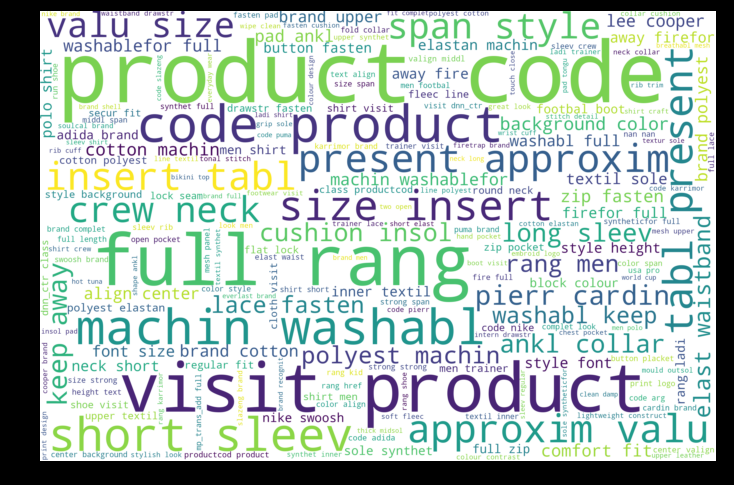

In [365]:
from wordcloud import WordCloud

X = " ".join(products.description_preprocessed.values)
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'white',
    stopwords = None).generate(X)

fig = plt.figure(
    figsize = (10, 10),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

<h1>Price</h1>

In [63]:
products = pd.read_csv("dataset_catalog.csv").drop(columns=['category_id','category_path','brand','gender', 'description'])
print(products.shape)
products.head()

(28369, 2)


,product_id,price
0,1,41.64
1,2,41.64
2,3,41.64
3,4,41.64
4,5,23.73


Most of the products have price from +-3 to 30 euro. Dataset contains lot of outliers with price more than 150.

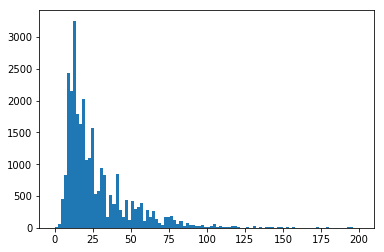

In [48]:
_ = plt.hist(products[products.price<200].price, bins=100)

In [64]:
prices = products.price.values.reshape(-1, 1)

Here I used NN model with metrics euclidean which returns absolute distance between prices. Because the distances can be any non-negative value I created own metrics for price similarity based on heuristics which converts values to 0.0-1.0 scale. It is calculated in distances_to_similarity method.

In [65]:
class PriceSimilarity(Similarity):
    
    def train(self, data):
        self.data = data
        self.model = NearestNeighbors(n_neighbors=5,  metric='euclidean')
        self.model.fit(data)
        
    def get_similarities(self, product_id):
        product_count = self.data.shape[0] 
        product_idx = product_id - 1
        distances, neighbours = self.model.kneighbors([self.data[product_idx]], product_count, return_distance=True)
        distances = distances.flatten()
        neighbours = neighbours.flatten()
        similarity = self._distances_to_similarity(distances)
        
        all_product_similarities = np.zeros(product_count)
        all_product_similarities[neighbours] = similarity
        
        return all_product_similarities
    
    def _distances_to_similarity(self, distances):
        similarity = np.zeros(distances.shape)
        similarity[distances <= 3] = 1 #when difference between price is less 3 euro the similarity is maximal
        similarity[(distances > 3) & (distances <=5)] = 0.9 #when difference between price is less than 5 and more than 3 euro
        similarity[(distances > 5) & (distances <=10)] = 0.8 #and so on...
        similarity[(distances > 10) & (distances <=25)] = 0.7
        similarity[(distances > 25) & (distances <=30)] = 0.6
        similarity[(distances > 30) & (distances <=40)] = 0.5
        similarity[(distances > 40) & (distances <=70)] = 0.4
        similarity[(distances > 70) & (distances <=100)] = 0.3
        similarity[(distances > 100) & (distances <=150)] = 0.2
        similarity[(distances > 150) & (distances <=250)] = 0.1
        return similarity


In [51]:
products.head(10)

,product_id,price
0,1,41.64
1,2,41.64
2,3,41.64
3,4,41.64
4,5,23.73
5,6,12.53
6,7,9.03
7,8,4.20
8,9,19.53
9,10,50.04


Testing the similarity based on price on first 10 products. Test product has product_id 5 - 23.73. The most similar is itself and product with id 8 - 19.53.

In [66]:
priceSimilarity = PriceSimilarity()
priceSimilarity.train(prices)

test_id1 = 5
priceSimilarity.get_similarities(test_id1)[:10]


array([0.7, 0.7, 0.7, 0.7, 1. , 0.7, 0.7, 0.7, 0.9, 0.6])

<h1>Combining similarity</h1>

Here I took all the classes and combined their outputs to single output. Every class is weighted. I set them heuristically. When we are making recommendations to a user probably the most important feature is gender. If a user was visiting man-only products it makes no sense to recommend items with similar price, brand or category if it for women. Thats why I set weight for gender the highest.

In [69]:
sim_classes = {
    'categorySimilarity': categorySimilarity,
    'brandSimilarity': brandSimilarity,
    'genderSimilarity': genderSimilarity,
    'priceSimilarity': priceSimilarity,
}
sim_weights = {
    'categorySimilarity': 0.2,
    'brandSimilarity': 0.1,
    'genderSimilarity': 0.5,
    'priceSimilarity': 0.2,
}

In [73]:
products = pd.read_csv("dataset_catalog.csv")
products.head()

,product_id,category_id,category_path,brand,gender,description,price
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
2,3,2,Clothes,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64
4,5,3,Children|Children's Footwear|Children's Sport ...,Nike,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",23.73


Following cell contains two methods. get_combined_similarity iterate over all models and saves its output which is then weighted to a single vector. get_n_most_similar_products returns n  products with highest combined similarity.

In [70]:
def get_combined_similarity(product_id):

    combined_similarity = np.zeros(products.shape[0]).astype(np.float)
    for name in sim_classes:
        sim = sim_classes[name].get_similarities(product_id)
        combined_similarity += sim * sim_weights[name]
    combined_similarity = combined_similarity/np.max(combined_similarity)
    return combined_similarity

def get_n_most_similar_products(combined_similarity, n=20):
    sorted_idxs = np.argsort(combined_similarity)[::-1]
    n_most_idxs = sorted_idxs[:n]
    n_most_products = n_most_idxs + 1
    similarities = combined_similarity[n_most_idxs]
    
    return n_most_products.tolist(), n_most_idxs.tolist(), similarities.tolist()



Testing the model results in reasonable output. (The output even looks like there are duplicated products. The reason does not make sense to me but it would be best to merge them (also merge customer interactions used in collaborative recommender model).)

In [75]:
test_id1 = 4411
combined_similarity = get_combined_similarity(test_id1)
n_most_products, n_most_idxs, similarities = get_n_most_similar_products(combined_similarity)

p = products.iloc[n_most_idxs].copy()
p['similarity'] = similarities
p

,product_id,category_id,category_path,brand,gender,description,price,similarity
4410,4411,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",55.23,1.00
4409,4410,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",55.23,1.00
4408,4409,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",55.23,1.00
0,1,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,0.94
1,2,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,0.94
3,4,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Firetrap,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",41.64,0.94
4403,4404,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Karrimor,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",53.83,0.90
4405,4406,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Karrimor,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",56.63,0.90
4404,4405,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Karrimor,Child,"<h2><!-- mp_trans_rt_start id=""1"" args=""as"" 5 ...",53.83,0.90
21073,21074,1,Sports|Outdoor|Outdoor Shoes|Children's Outdoo...,Karrimor,Child,"<p id=""dnn_ctr103511_ViewTemplate_ctl00_ctl21_...",46.83,0.86


<h1>Recommendations</h1>

In [78]:
events = pd.read_csv("dataset_events.csv")
print(events.shape)
events.head()

(653419, 4)


,customer_id,product_id,type,timestamp
0,1,19685,view_product,1527812004
1,1,19685,view_product,1527812041
2,1,19685,add_to_cart,1527812046
3,1,19685,view_product,1527812048
4,1,19685,view_product,1527812050


Following method makes recommendations based on similarity of products that an user had seen before. If an users visited products with ids 1, 2, 3, 4 (in this order) and we want 50 products to recommend, then 13 most similar products to product 4, 13 most similar products to 3, 12 most similar products to product 2 and 12 most similar products to produt 1 are recommended. The recommended products are not shuffled. The fist recommended products are the most similar to the product that the user had seen as last. The final version of this method takes already visited and already recommended item in account. These are not recommended anymore.

In [82]:
def recommend(customer_id, n=50):
    customer_products = events[events.customer_id == test_customer_id].sort_values('timestamp', ascending=False).product_id.values

    combined_similarity = np.zeros(products.shape[0])
    recommended_items = []
    n_cut = np.repeat(n // len(customer_products), len(customer_products))
    n_rest = n % len(customer_products)
    i = 0
    while n_rest != 0:
        n_cut[i%len(n_cut)] += 1
        n_rest -= 1
        i += 1
    for i, product_id in enumerate(customer_products):
        if len(recommended_items) >= n: break
        combined_similarity = get_combined_similarity(product_id)
        n_most_products, n_most_idxs, similarities = get_n_most_similar_products(combined_similarity, n_cut[i])

        recommended_items += n_most_products
    return recommended_items

recommended_items = recommend(test_customer_id, 8)
recommended_items

[21120, 4609, 19922, 21120, 19922, 21120, 19922, 19922]

In the third notoebook I created very simple recommender for users without any interacion.